In [3]:
import pandas as pd
import numpy as np
import pyodbc
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [4]:
conn_str=(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=MARIAMGHAREEB;'
    'DATABASE=Chinook;'
    'Trusted_Connection=yes;'
    
)

In [5]:
conn=pyodbc.connect(conn_str)

In [6]:
# Albums
query = "SELECT * FROM dbo.Album"
albums_df = pd.read_sql(query, conn)

# Artists
query = "SELECT * FROM dbo.Artist"
artists_df = pd.read_sql(query, conn)

# Customers
query = "SELECT * FROM dbo.Customer"
customers_df = pd.read_sql(query, conn)

# Employees
query = "SELECT * FROM dbo.Employee"
employees_df = pd.read_sql(query, conn)

# Genres
query = "SELECT * FROM dbo.Genre"
genres_df = pd.read_sql(query, conn)

# Invoices
query = "SELECT * FROM dbo.Invoice"
invoices_df = pd.read_sql(query, conn)

# Invoice Lines
query = "SELECT * FROM dbo.InvoiceLine"
invoice_lines_df = pd.read_sql(query, conn)

# Media Types
query = "SELECT * FROM dbo.MediaType"
media_types_df = pd.read_sql(query, conn)

# Playlists
query = "SELECT * FROM dbo.Playlist"
playlists_df = pd.read_sql(query, conn)

# Playlist Tracks
query = "SELECT * FROM dbo.PlaylistTrack"
playlist_tracks_df = pd.read_sql(query, conn)

# Tracks
query = "SELECT * FROM dbo.Track"
tracks_df = pd.read_sql(query, conn)

In [9]:
# Create a dictionary of dataframes for easy iteration
dfs = {
    "Albums": albums_df,
    "Artists": artists_df,
    "Customers": customers_df,
    "Employees": employees_df,
    "Genres": genres_df,
    "Invoices": invoices_df,
    "Invoice Lines": invoice_lines_df,
    "Media Types": media_types_df,
    "Playlists": playlists_df,
    "Playlist Tracks": playlist_tracks_df,
    "Tracks": tracks_df
}

# Loop through each dataframe to show .info() and .describe()
for name, df in dfs.items():
    print(f"\n{'='*40}\n{name} - .info()\n{'='*40}")
    df.info()
    


Albums - .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   AlbumId   347 non-null    int64 
 1   Title     347 non-null    object
 2   ArtistId  347 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.3+ KB

Artists - .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ArtistId  275 non-null    int64 
 1   Name      275 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.4+ KB

Customers - .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerId    59 non-null     int64 
 1   FirstName     59 non-null     object
 2   LastName      59

In [10]:
revenue_data=invoice_lines_df.merge(invoices_df,on="InvoiceId")
total_revenue=(revenue_data["UnitPrice"]*revenue_data["Quantity"]).sum()
avg_order_value=invoices_df["Total"].mean()
date_range=f"{invoices_df['InvoiceDate'].min().strftime('%Y-%m-%d')} to {invoices_df['InvoiceDate'].max().strftime('%Y-%m-%d')}"


In [11]:
customer_revenue=revenue_data.groupby("CustomerId")["UnitPrice"].sum()

In [12]:
customer_geo=customers_df["Country"].value_counts()
revenue_geo=(invoices_df.groupby("BillingCountry")["Total"].agg(
    ["sum","count","mean"]
).round(2).sort_values('sum',ascending=False))

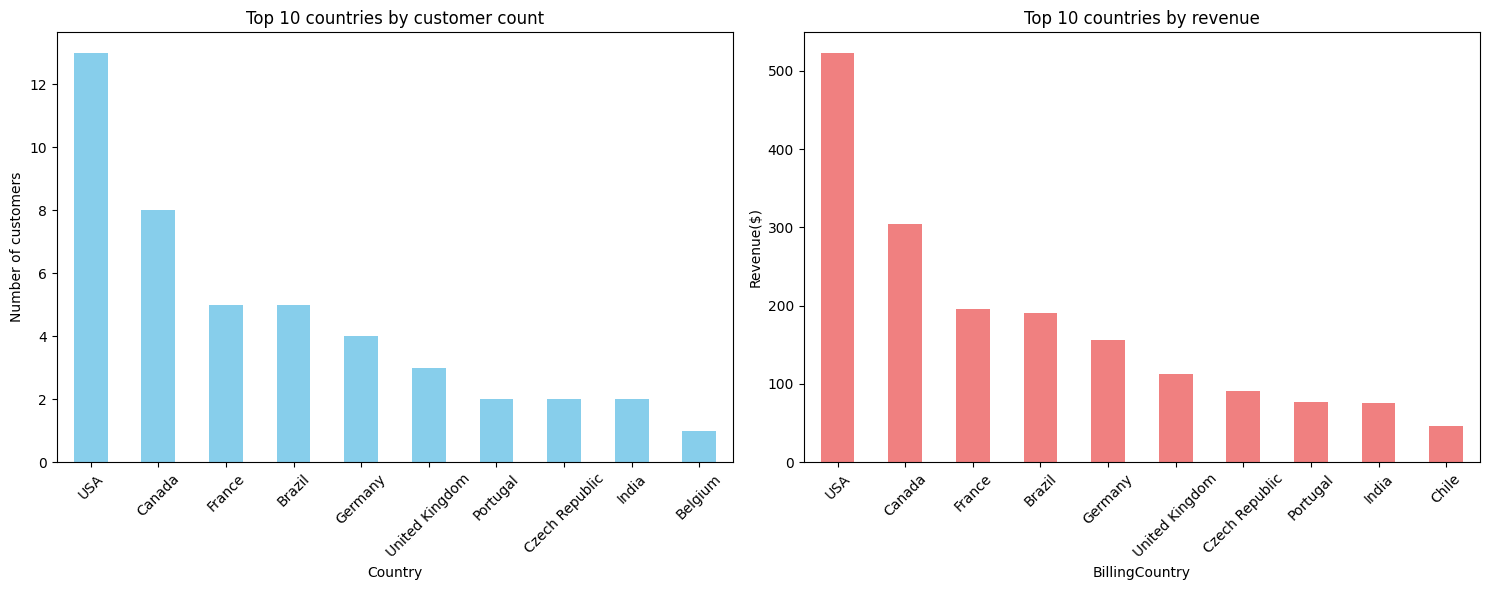

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,6))
customer_geo.head(10).plot(kind='bar',ax=ax1,color='skyblue')
ax1.set_title("Top 10 countries by customer count")
ax1.set_ylabel("Number of customers")
ax1.tick_params(axis="x",rotation=45)
revenue_geo.head(10)['sum'].plot(kind='bar',ax=ax2,color="lightcoral")
ax2.set_title("Top 10 countries by revenue")
ax2.set_ylabel("Revenue($)")
ax2.tick_params(axis="x",rotation=45)
plt.tight_layout()
plt.show()

In [21]:
product_sales=(
    invoice_lines_df
    .merge(tracks_df,on='TrackId')
    .merge(albums_df,on="AlbumId")
    .merge(artists_df,on='ArtistId')
    .merge(genres_df,on="GenreId")
    
)

In [29]:
if 'UnitPrice_x' in product_sales.columns:
    product_sales['Revenue'] = product_sales['UnitPrice_x'] * product_sales['Quantity']
elif 'UnitPrice' in product_sales.columns:
    product_sales['Revenue'] = product_sales['UnitPrice'] * product_sales['Quantity']
else:
    # Debug: print available columns
    print("Available columns:", product_sales.columns.tolist())
    # Use first UnitPrice column found
    unitprice_cols = [col for col in product_sales.columns if 'UnitPrice' in col]
    if unitprice_cols:
        product_sales['Revenue'] = product_sales[unitprice_cols[0]] * product_sales['Quantity']
    else:
        print("Warning: No UnitPrice column found!")

# Top Artists by Revenue - handle potential column naming issues
if 'Name_y' in product_sales.columns:
    artist_col = 'Name_y'
elif any('Name' in col for col in product_sales.columns):
    artist_col = [
        col for col in product_sales.columns 
        if 'Name' in col and ('Artist' in str(product_sales.columns.get_loc(col)) or col.endswith('_y'))
    ][0]
else:
    artist_col = 'Name'

artist_performance = (
    product_sales.groupby(artist_col)
    .agg({
        'Revenue': 'sum',
        'Quantity': 'sum',
        'TrackId': 'nunique'
    })
    .round(2)
    .sort_values('Revenue', ascending=False)
)



In [31]:
        # Genre Performance - handle column naming
genre_col = 'Name' if 'Name' in product_sales.columns else [col for col in product_sales.columns if 'Name' in col and col != artist_col][0]
genre_performance = (
            product_sales.groupby(genre_col)
            .agg({
                'Revenue': 'sum',
                'Quantity': 'sum',
            })
            .round(2)
            .sort_values('Revenue', ascending=False)
        )

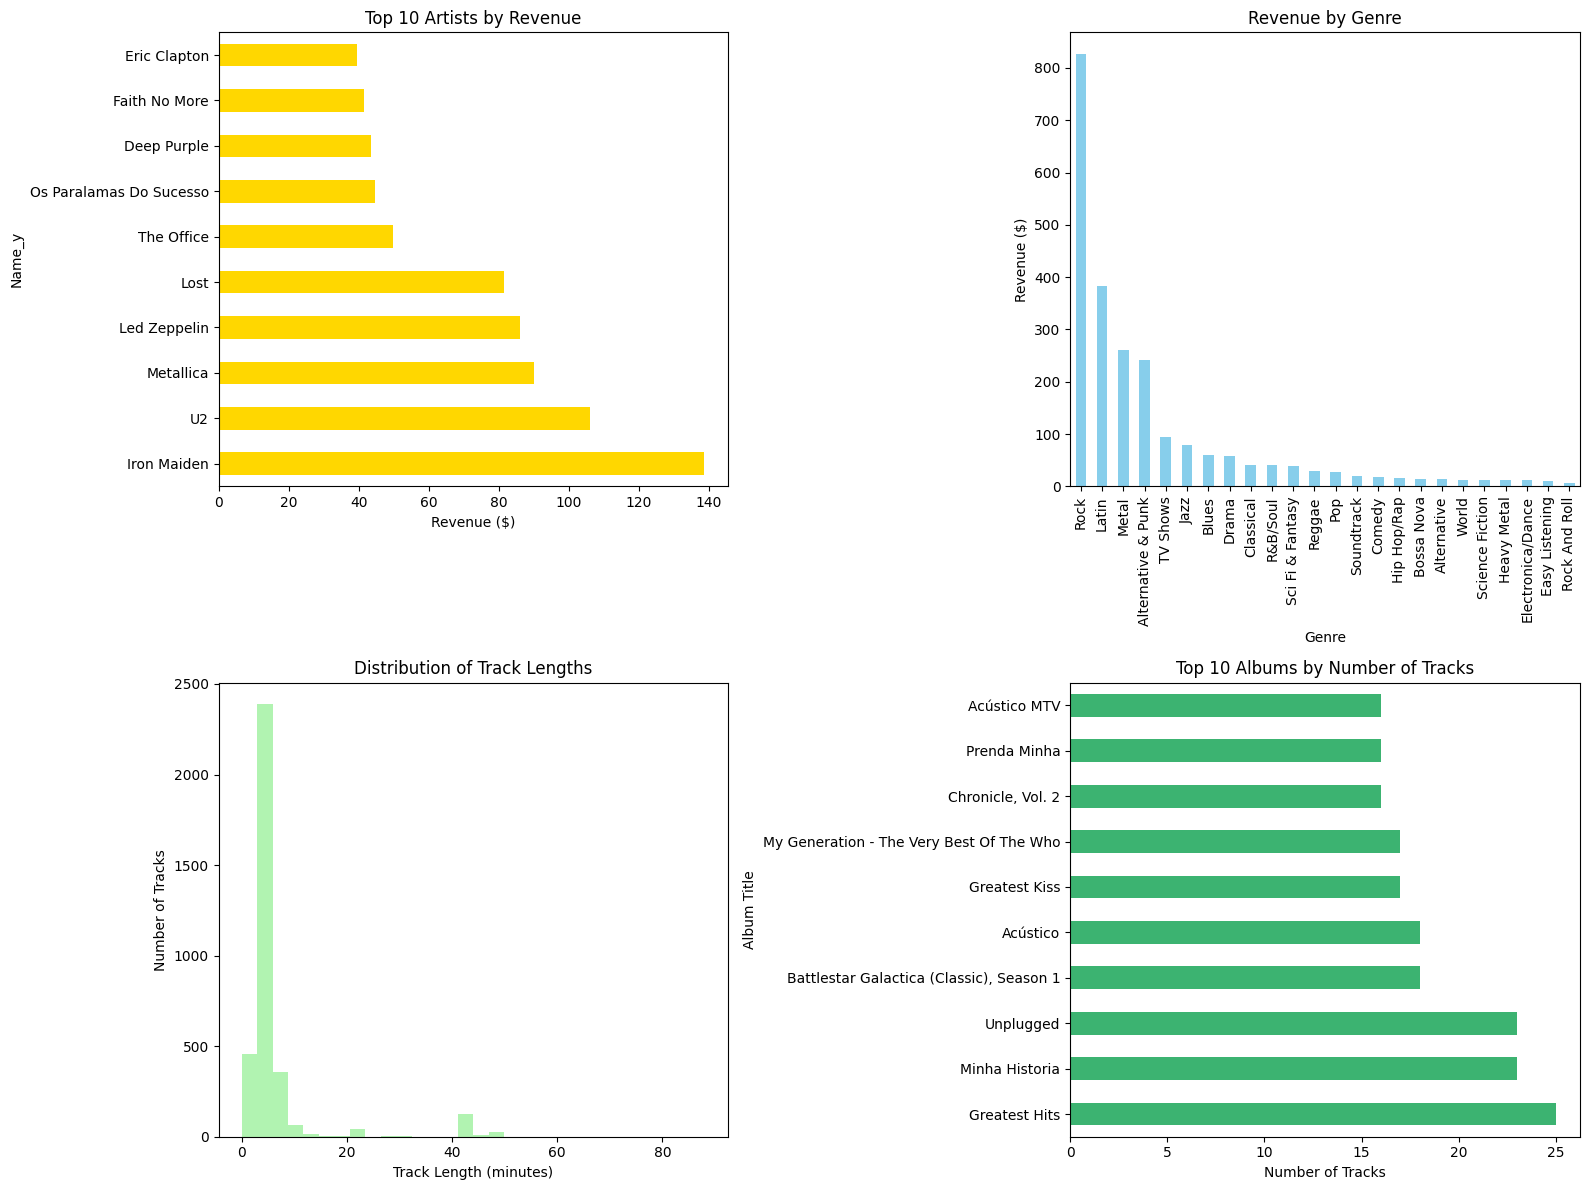

In [44]:
# Visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Top Artists
artist_performance.head(10)['Revenue'].plot(kind='barh', ax=ax1, color='gold')
ax1.set_title('Top 10 Artists by Revenue')
ax1.set_xlabel('Revenue ($)')

# Genre Distribution (as bar chart instead of pie)
genre_performance['Revenue'].plot(kind='bar', ax=ax2, color='skyblue')
ax2.set_title('Revenue by Genre')
ax2.set_ylabel('Revenue ($)')
ax2.set_xlabel('Genre')

# Track Length Analysis
track_length = tracks_df['Milliseconds'] / 60000  # Convert to minutes
ax3.hist(track_length, bins=30, color='lightgreen', alpha=0.7)
ax3.set_title('Distribution of Track Lengths')
ax3.set_xlabel('Track Length (minutes)')
ax3.set_ylabel('Number of Tracks')

# New Insight: Top Albums by Number of Tracks
top_albums = (
    product_sales.groupby('Title')['TrackId']
    .nunique()
    .sort_values(ascending=False)
    .head(10)
)
top_albums.plot(kind='barh', ax=ax4, color='mediumseagreen')
ax4.set_title('Top 10 Albums by Number of Tracks')
ax4.set_xlabel('Number of Tracks')
ax4.set_ylabel('Album Title')

plt.tight_layout()
plt.show()


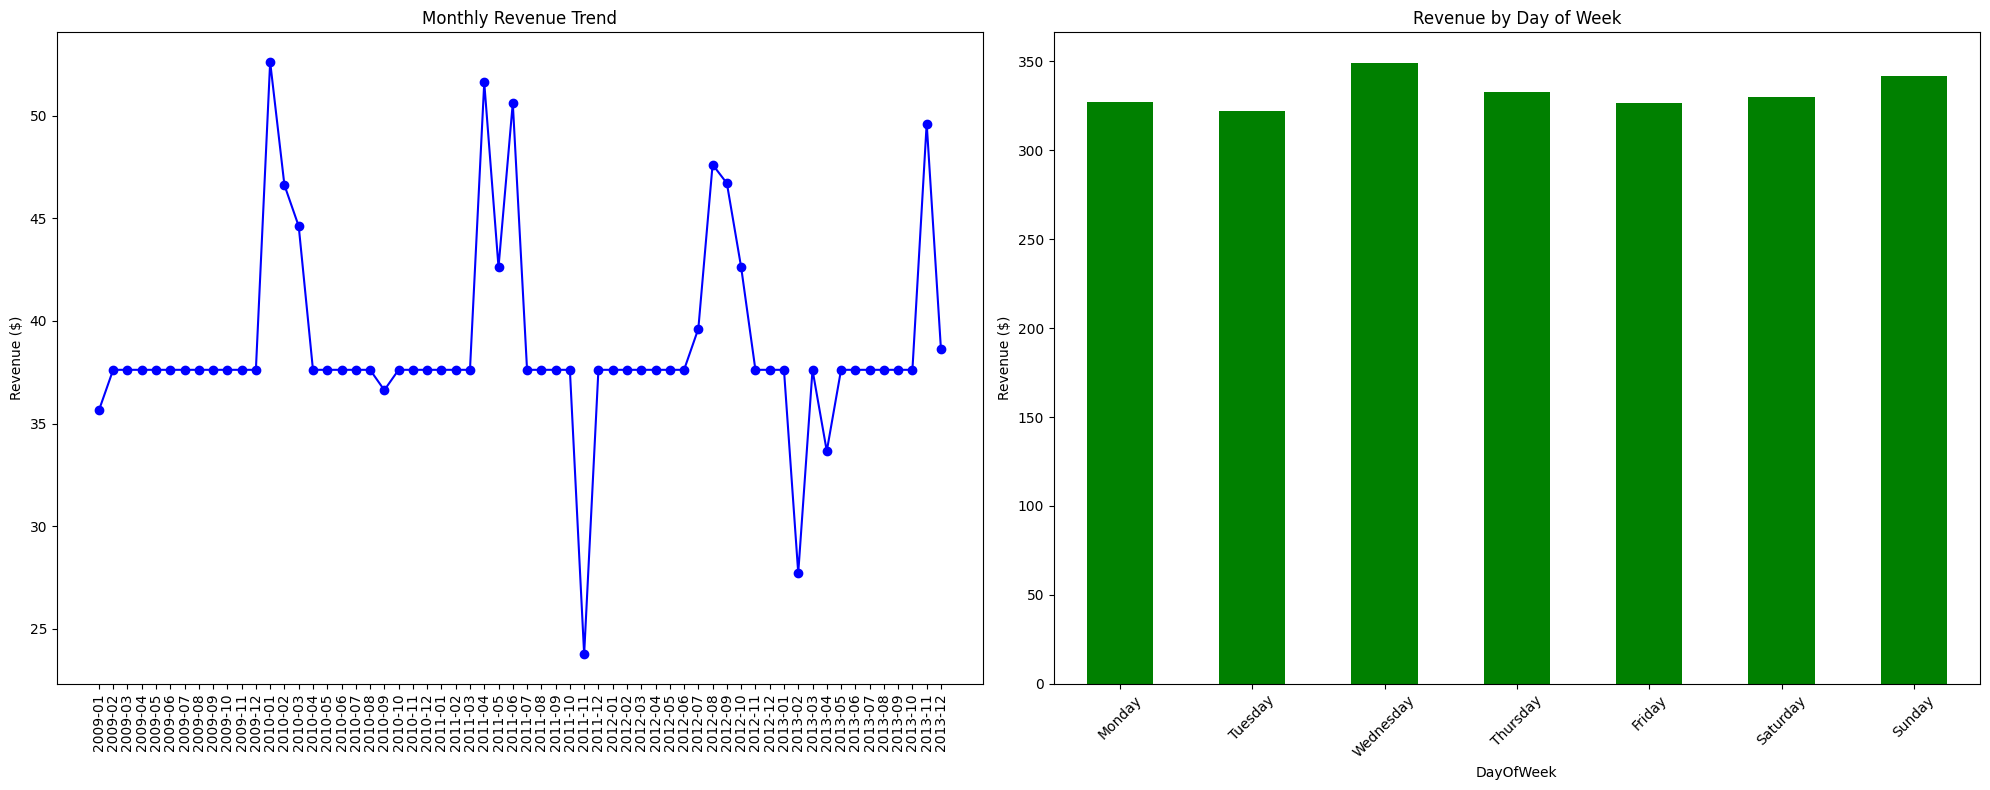

In [58]:
# Add time features
invoices_df['Year'] = invoices_df['InvoiceDate'].dt.year
invoices_df['Month'] = invoices_df['InvoiceDate'].dt.month
invoices_df['DayOfWeek'] = invoices_df['InvoiceDate'].dt.day_name()

# Monthly trends
monthly_sales = (
    invoices_df.groupby(['Year', 'Month'])
    .agg({
        'Total': ['sum', 'count', 'mean'],
        'CustomerId': 'nunique'
    })
    .round(2)
)

# Day of week patterns
dow_analysis = (
    invoices_df.groupby('DayOfWeek')
    .agg({
        'Total': ['sum', 'count', 'mean'],
        'CustomerId': 'nunique'
    })
    .round(2)
)

# Visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Monthly revenue trend
monthly_revenue = monthly_sales[('Total', 'sum')].reset_index()
monthly_revenue['Period'] = monthly_revenue['Year'].astype(str) + '-' + monthly_revenue['Month'].astype(str).str.zfill(2)
ax1.plot(monthly_revenue['Period'], monthly_revenue[('Total', 'sum')], marker='o', color='blue')
ax1.set_title('Monthly Revenue Trend')
ax1.set_ylabel('Revenue ($)')
ax1.tick_params(axis='x', rotation=90)

# Day of week analysis
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_ordered = dow_analysis.reindex(day_order)
dow_ordered[('Total', 'sum')].plot(kind='bar', ax=ax2, color='green')
ax2.set_title('Revenue by Day of Week')
ax2.set_ylabel('Revenue ($)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [61]:
print("\n" + "="*80)
print("📋 EXECUTIVE SUMMARY - CHINOOK MUSIC DATABASE ANALYSIS")
print("="*80)

# Get key metrics
revenue_data = invoice_lines_df.merge(invoices_df, on='InvoiceId')
total_revenue = (revenue_data['UnitPrice'] * revenue_data['Quantity']).sum()

full_data = (
    invoice_lines_df
    .merge(invoices_df, on='InvoiceId')
    .merge(tracks_df, on='TrackId')
    .merge(albums_df, on='AlbumId')
    .merge(artists_df, on='ArtistId')
    .merge(genres_df, on='GenreId')
)

# Top countries
top_countries = invoices_df.groupby('BillingCountry')['Total'].sum().nlargest(3)


print(f"🎵 BUSINESS PERFORMANCE:")
print(f"   • Total Revenue: ${total_revenue:,.2f}")
print(f"   • Customer Base: {len(customers_df):,} customers across {customers_df['Country'].nunique()} countries")
print(f"   • Product Catalog: {len(tracks_df):,} tracks from {len(artists_df):,} artists")
print(f"   • Order Volume: {len(invoices_df):,} completed orders")

print(f"\n🌍 TOP MARKETS:")
for country, revenue in top_countries.items():
    print(f"   • {country}: ${revenue:,.2f}")

print(f"\n🎼 TOP GENRES:")
for genre, revenue in top_genres.items():
    print(f"   • {genre}: ${revenue:,.2f}")

print(f"\n🔑 KEY INSIGHTS:")
print(f"   • Average order value: ${invoices_df['Total'].mean():.2f}")
print(f"   • Customer lifetime value: ${(revenue_data.groupby('CustomerId')['UnitPrice'].sum().mean()):.2f}")
print(f"   • Most popular media type: {tracks_df.merge(media_types_df, on='MediaTypeId')['Name_y'].mode().iloc[0]}")
print(f"   • Average track length: {(tracks_df['Milliseconds'].mean()/60000):.1f} minutes")

print(f"\n📈 GROWTH OPPORTUNITIES:")
print(f"   • Expand in emerging markets with lower penetration")
print(f"   • Cross-sell complementary genres based on purchase patterns")
print(f"   • Develop loyalty programs for repeat customers")
print(f"   • Optimize pricing strategy based on demand elasticity")

print("="*80)



📋 EXECUTIVE SUMMARY - CHINOOK MUSIC DATABASE ANALYSIS
🎵 BUSINESS PERFORMANCE:
   • Total Revenue: $2,328.60
   • Customer Base: 59 customers across 24 countries
   • Product Catalog: 3,503 tracks from 275 artists
   • Order Volume: 412 completed orders

🌍 TOP MARKETS:
   • USA: $523.06
   • Canada: $303.96
   • France: $195.10

🎼 TOP GENRES:
   • Rock: $826.65
   • Latin: $382.14
   • Metal: $261.36
   • Alternative & Punk: $241.56
   • TV Shows: $93.53
   • Jazz: $79.20

🔑 KEY INSIGHTS:
   • Average order value: $5.65
   • Customer lifetime value: $39.47
   • Most popular media type: MPEG audio file
   • Average track length: 6.6 minutes

📈 GROWTH OPPORTUNITIES:
   • Expand in emerging markets with lower penetration
   • Cross-sell complementary genres based on purchase patterns
   • Develop loyalty programs for repeat customers
   • Optimize pricing strategy based on demand elasticity
